In [2]:
import sys
import os
import tensorflow as tf
import sklearn
import numpy as n
import pandas
import cv2
import gc
import keras
import matplotlib.pyplot as plt

opj = os.path.join

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, Lambda, MaxPooling2D, Dropout
from keras import backend as K

Using TensorFlow backend.


## Data pre-processing utility functions

In [3]:
def tf_rgb_to_grayscale(x):
    import tensorflow as tf
    return tf.image.rgb_to_grayscale(x)

def get_training_data(csv_abs_path, img_base_directory, cameras, measurement_keys, resize=None, crop=True, flip=True):
    '''
    Get image training data and labels from csv and image files
    :param csv_abs_path: a string holds absolute path to csv file
    :param img_base_directory: a string holds absolution parent directory path where images are stored
    :param cameras: a list of strings for which cameras would be used/
    :param measurement_keys: by default steering
    :return: 
    '''
    # some preparations
    images = []
    measurements = []
    dataframe = pandas.read_csv(csv_abs_path)
    
    for camera in cameras:
        img_abs_paths = dataframe[camera].values
        for img_abs_path in img_abs_paths:            
            # read image
            img = n.array(cv2.imread(img_abs_path))
            if crop:
                img = img[60:,:]
            if resize is not None:
                img = cv2.resize(img, resize)
            images.append(img)

            # flip image data
            if flip:
                image_flip = n.fliplr(img)
                images.append(image_flip)

    # get measurement data
    for measurement_key in measurement_keys:
        measurement_values = dataframe[measurement_key].values
        for measurement in measurement_values:
            measurements.append(measurement)

            # flip image data needs to flip the measurement too
            if flip:
                measurements.append(-1.0 * measurement)

    X_train = n.array(images)
    y_train = n.array(measurements).flatten()
    
    return X_train, y_train

## Network definition

In [4]:
# define the network here
def keras_network(X_train, y_train, option='linear', save_fname='test.h5'):
    if option == 'linear':
        model = Sequential()
        model.add(Lambda(tf_rgb_to_grayscale, input_shape=X_train[0].shape))
        model.add(Lambda(lambda x: x/255.0-0.5, input_shape=X_train[0].shape[:2] + (1,)))
        model.add(Flatten())
        model.add(Dense(1))

    elif option == 'CNN':
        model = Sequential()
        model.add(Lambda(tf_rgb_to_grayscale, input_shape=X_train[0].shape))
        model.add(Lambda(lambda x: x/255.0-0.5, input_shape=X_train[0].shape[:2] + (1,)))
        model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.25))

        model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.25))

#         model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(100))
#         model.add(Dropout(0.5))
        model.add(Dense(1))
        
    model.compile(loss='mse', optimizer='adam')
    history_obj = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=10, verbose=1)
        
    model.save(opj('./trained_model', save_fname))
    K.clear_session()
    return history_obj
    
def tf_network(X_train, y_train):
    pass

def visualize_model_history(history_object):
    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

## Data pre-processing

In [5]:
# train data dict
train_data_dict = {
    'track1_t1_p': './train_data/track1_t1',
    'track1_t1_csv': './train_data/track1_t1/driving_log.csv',
    'track1_t2_p': './train_data/track1_t2',
    'track1_t2_csv': './train_data/track1_t2/driving_log.csv',
    'sample_data_p': './train_data/sample_data',
    'sample_data_csv': './train_data/sample_data/driving_log.csv'
}

# toggle the training option
train_option = 'track1_t2'
train_data_p = train_option + '_p'
train_data_csv = train_option + '_csv'

# load training dataset
csv_abs_path = train_data_dict[train_data_csv]
img_base_directory = train_data_dict[train_data_p]
cameras = ['center']
measurement_keys = ['steering']

# get pre-processed training data set
X_train, y_train = get_training_data(csv_abs_path, img_base_directory, cameras, measurement_keys, resize=(64,64), crop=True, flip=True)

## Execution of the Network

Train on 10403 samples, validate on 2601 samples
Epoch 1/10
10403/10403 [==============================] - 8s 737us/step - loss: 0.0529 - val_loss: 0.2076
Epoch 2/10
10403/10403 [==============================] - 7s 721us/step - loss: 0.0240 - val_loss: 0.1504
Epoch 3/10
10403/10403 [==============================] - 8s 783us/step - loss: 0.0192 - val_loss: 0.1547
Epoch 4/10
10403/10403 [==============================] - 8s 784us/step - loss: 0.0179 - val_loss: 0.1777
Epoch 5/10
10403/10403 [==============================] - 8s 754us/step - loss: 0.0169 - val_loss: 0.1881
Epoch 6/10
10403/10403 [==============================] - 8s 754us/step - loss: 0.0164 - val_loss: 0.1771
Epoch 7/10
10403/10403 [==============================] - 8s 772us/step - loss: 0.0151 - val_loss: 0.2245
Epoch 8/10
10403/10403 [==============================] - 8s 763us/step - loss: 0.0145 - val_loss: 0.2139
Epoch 9/10
10403/10403 [==============================] - 8s 761us/step - loss: 0.0140 - val_loss: 0.21

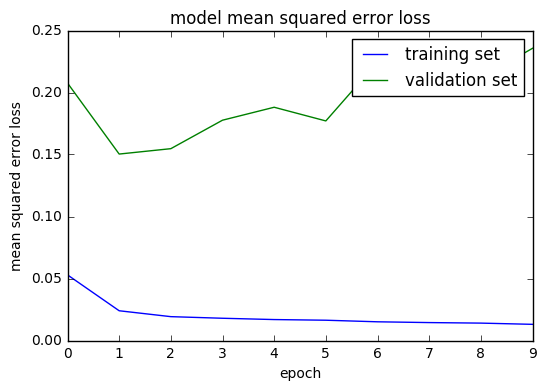

In [10]:
history_obj = keras_network(X_train, y_train, option='CNN')
visualize_model_history(history_obj)

In [5]:
track2_df = pandas.read_csv('train_data/driving_log.csv')
valid_keys = ['center']
measurement_keys = ['steering']

In [8]:
track2_images = []
measurements = []
from keras import backend as K

def tf_rgb_to_grayscale(x):
    import tensorflow as tf
    return tf.image.rgb_to_grayscale(x)

# get image data
for valid_key in valid_keys:
    valid_paths = track2_df[valid_key].values
    for valid_path in valid_paths:
        abs_path = valid_path
        image = cv2.imread(abs_path)
        track2_images.append(image)
        
        # flip image data
        image_flip = n.fliplr(image)
        track2_images.append(image_flip)

# get measurement data
for measurement_key in measurement_keys:
    measurement_values = track2_df[measurement_key].values
    for measurement in measurement_values:
        measurements.append(measurement)
        
        # flip image data needs to flip the measurement too
        measurements.append(-1.0 * measurement)

X_train = n.array(track2_images)
y_train = n.array(measurements).flatten()

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, Lambda

# define the network here
model = Sequential()
model.add(Lambda(tf_rgb_to_grayscale, input_shape=X_train[0].shape))
model.add(Lambda(lambda x: x/255.0-0.5, input_shape=(160,320,1)))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=10)

model.save('./trained_model/test.h5')

K.clear_session()

Train on 6406 samples, validate on 1602 samples
Epoch 1/10
6406/6406 [==============================] - 7s 1ms/step - loss: 0.3464 - val_loss: 0.3102
Epoch 2/10
6406/6406 [==============================] - 7s 1ms/step - loss: 0.5874 - val_loss: 0.3002
Epoch 3/10
6406/6406 [==============================] - 7s 1ms/step - loss: 0.5162 - val_loss: 0.2283
Epoch 4/10
6406/6406 [==============================] - 7s 1ms/step - loss: 0.4352 - val_loss: 0.2661
Epoch 5/10
6406/6406 [==============================] - 7s 1ms/step - loss: 0.5214 - val_loss: 0.2094
Epoch 6/10
6406/6406 [==============================] - 7s 1ms/step - loss: 0.7494 - val_loss: 0.2561
Epoch 7/10
6406/6406 [==============================] - 7s 1ms/step - loss: 0.4830 - val_loss: 0.6055
Epoch 8/10
6406/6406 [==============================] - 7s 1ms/step - loss: 0.3722 - val_loss: 0.1353
Epoch 9/10
6406/6406 [==============================] - 7s 1ms/step - loss: 0.5324 - val_loss: 0.4253
Epoch 10/10
6406/6406 [===========

In [9]:
import gc
gc.collect()

2730

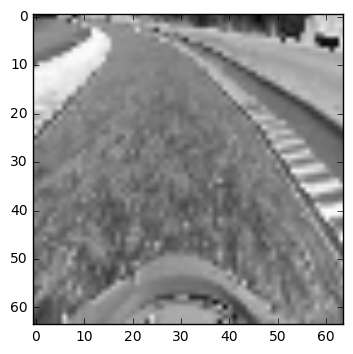

In [11]:
def rgb2gray(rgb):
    return n.dot(rgb[...,:3], [0.299, 0.587, 0.114])

plt.imshow(rgb2gray(X_train[0]), cmap='gray'); plt.show()